In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm_notebook
progress = tqdm_notebook()

RAW_DATA_DIR = '../data/raw/'
CLEAN_DATA_DIR = '../data/clean/'

Widget Javascript not detected.  It may not be installed or enabled properly.


In [2]:
flagged = pd.read_csv(RAW_DATA_DIR+'400k_flag_v2.csv')
flagged.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,patient_id,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
0,10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Import and process data


### Demographics

In [3]:
demographics_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True)
demographics_raw.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEX,RACE,ETHNICITY,DOB,DOD,ZIP_CODE
MRN,,,,,,
28997286,2,7,UN,1958-01-09,NaN,422100000
22710289,2,2,NH,1969-09-11,NaN,370640000
15333065,1,1,NH,1996-12-28,NaN,372060000
11732831,1,2,NH,1991-01-31,NaN,370400000
26724542,2,1,NH,1958-08-19,NaN,421340000


In [4]:
demographics_raw.shape

(529428, 6)

In [5]:
demographics_raw.index.is_unique

True

Recode categorical variables to something useful

In [6]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [7]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [8]:
demographics_raw.race.value_counts()

white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [9]:
demographics_raw.ETHNICITY.value_counts()

NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [10]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [11]:
demographics_raw.isnull().mean()

SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

Drop date of death and ethnicity

In [12]:
demographics = demographics_raw.drop(['DOD', 'ETHNICITY'], axis=1)

In [13]:
demographics.shape

(529428, 7)

### Patient flags

In [14]:
flags = pd.read_csv(RAW_DATA_DIR + '400k_flag_v2.csv', index_col=0)
flags.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
patient_id,,,,,,,,,,,,,,,,,
10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
flagged_demographics = demographics.join(flags)
flagged_demographics.shape

(529428, 24)

### Height measurements

Perhaps choose modal or median for each patient.

In [16]:
height_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

,MRN,HEIGHT_DATE,HEIGHT
0,1887330,2016-02-22,157.48
1,1887330,2012-01-17,162.56
2,1887330,2013-02-15,162.56
3,1887330,2013-05-17,162.56
4,1887330,2013-08-07,162.56


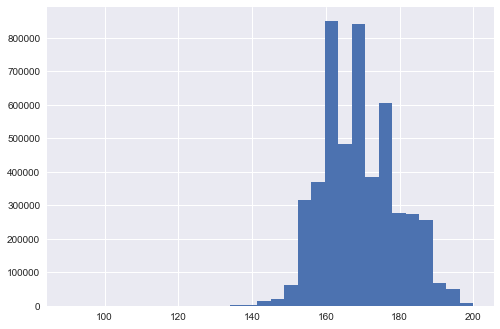

In [17]:
plt.figure()
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### Weight data

In [18]:
weight_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR
0,7695679,2006-01-27,62.60,1
1,7695679,2006-02-08,62.60,1
2,7695679,2006-02-08,62.60,1
3,7695679,2006-03-08,63.96,1
4,7695679,2006-10-02,65.77,1


Only take individuals with 5 or more observations

In [46]:
weights_nonpreg = weight_raw[weight_raw.PREGNANCY_INDICATOR==0].drop('PREGNANCY_INDICATOR', axis=1)

In [47]:
weight_counts = weights_nonpreg.groupby('MRN')['WEIGHT_DATE'].count()

In [48]:
MIN_MEASUREMENTS = 11
min_weights = weight_counts[weight_counts>=MIN_MEASUREMENTS].index.values

In [50]:
filtered_weights = weights_nonpreg[weights_nonpreg.MRN.isin(min_weights)]

In [52]:
def calc_rel_date(patient):
    return patient.WEIGHT_DATE - patient.WEIGHT_DATE.min()

recalculate_relative_date = False

if recalculate_relative_date:
    progress.pandas(desc='relative date calculation')
    
    relative_date = filtered_weights.groupby('MRN').progress_apply(calc_rel_date)
    relative_date.index = relative_date.index.droplevel('MRN')
    relative_date.name = 'RELATIVE_DATE'
    
    relative_date.to_csv(CLEAN_DATA_DIR+'relative_date.csv')
else:
    relative_date = pd.read_csv(CLEAN_DATA_DIR+'relative_date.csv',
                               index_col=0)

195132/|/100%|| 195132/195132 [05:30<00:00, 597.42it/s]

In [53]:
weights = pd.concat([filtered_weights, relative_date], axis=1)

In [54]:
assert not weights.isnull().sum().any()

Apply Greevy flagging algorihtm

In [55]:
from scipy.stats import chi2

def calc_concordance(patient, m=-0.032, sd=3.52):
    p = []
    nobs = 11
    for i,x in patient.iterrows():

        # Calculate deltas
        df = (pd.DataFrame({'uid':i, 
                           'delta_W':patient.WEIGHT - x.WEIGHT, 
                           'delta_T':(patient.WEIGHT_DATE - x.WEIGHT_DATE).dt.days.abs()})
             .sort_values('delta_T')[1:nobs] 
             .assign(measurement=np.arange(1, nobs), weight_date=x.WEIGHT_DATE)) 

        # Calculate statistic
        prob = 1 - chi2.cdf(((df.delta_W - m)/sd) ** 2, 1) 

        # Convert to concordance probability
        p.append({'uid':i, 'p':prob.mean()})


    return pd.DataFrame(p).set_index('uid')


In [56]:
recalculate_weights = False

if recalculate_weights:
    progress.pandas(desc='concordance probability calculation')
    concordance = (filtered_weights.groupby('MRN')
                   .progress_apply(calc_concordance))
    concordance.to_csv(CLEAN_DATA_DIR+'concordance.csv')
else:
    concordance = pd.read_csv(CLEAN_DATA_DIR+'concordance.csv', index_col=0)

195132/|/100%|| 195132/195132 [9:59:09<00:00, 16.91it/s]

Add a relative date (to first measurement) of each measurement

In [58]:
concordance.index = concordance.index.droplevel('MRN')

In [59]:
(concordance<0.01).mean()

p    0.004729
dtype: float64

Proportion excluded as a function of concordance threshold.

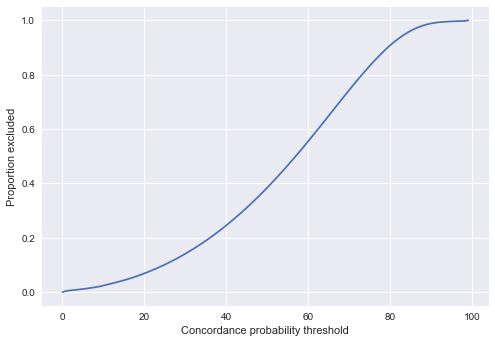

In [60]:
plt.figure()
plt.plot([(concordance<p).mean() for p in np.linspace(0, 1, 100)])
plt.xlabel('Concordance probability threshold')
plt.ylabel('Proportion excluded');

Merge concordance probabilities

In [61]:
concordance.shape

(5917001, 1)

In [69]:
weights = weights.join(concordance)

In [71]:
weights.head()

,MRN,WEIGHT_DATE,WEIGHT,RELATIVE_DATE,p
1088,2757748,2011-04-14,68.90,1497 days,0.115329
1089,2757748,2011-09-15,69.60,1651 days,0.130029
1090,2757748,2011-07-15,73.03,1589 days,0.126661
1091,2757748,2011-04-14,75.21,1497 days,0.209360
1092,2757748,2011-03-17,78.02,1469 days,0.077993


In [72]:
weights['Weight_filtered'] = weights.WEIGHT.copy()
weights.loc[weights.p<0.05, 'Weight_filtered'] = np.nan

In [73]:
len(set(weight_raw.MRN))

526996

Add age to each measurement

In [76]:
weights = weights.merge(demographics[['DOB']], left_on='MRN', right_index=True)
weights['AGE'] = (weights.WEIGHT_DATE - weights.DOB).astype('<m8[Y]')

Calculate BMI

In [77]:
bmi = weights.merge(height_raw, left_on=['MRN', 'WEIGHT_DATE'], 
              right_on=['MRN', 'HEIGHT_DATE'])
bmi['BMI'] = bmi.Weight_filtered / (bmi.HEIGHT / 100)**2

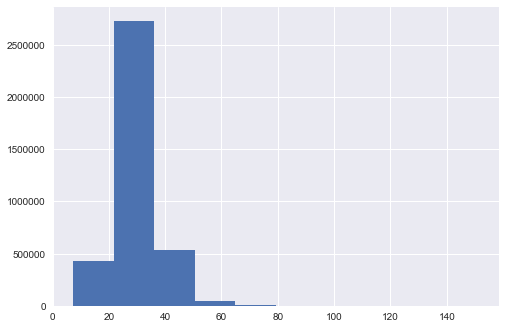

In [78]:
bmi.BMI.hist()

In [79]:
bmi.to_csv(CLEAN_DATA_DIR+'bmi.csv')

In [11]:
bmi = pd.read_csv(CLEAN_DATA_DIR+'bmi.csv', index_col=0, parse_dates=True)

In [17]:
bmi['RELATIVE_DATE'] = bmi.RELATIVE_DATE.str.split(' ').apply(lambda x: int(x[0]))

In [18]:
bmi.head()

,MRN,WEIGHT_DATE,WEIGHT,RELATIVE_DATE,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
0,2757748,2011-04-14,68.90,1497,0.115329,68.90,1957-12-09,53.0,2011-04-14,182.88,20.600929
1,2757748,2011-04-14,75.21,1497,0.209360,75.21,1957-12-09,53.0,2011-04-14,182.88,22.487603
2,2757748,2011-03-17,78.02,1469,0.077993,78.02,1957-12-09,53.0,2011-03-17,182.88,23.327786
3,2757748,2016-06-30,88.18,3401,0.172913,88.18,1957-12-09,58.0,2016-06-30,180.34,27.113524
4,2757748,2016-11-09,90.26,3533,0.336338,90.26,1957-12-09,58.0,2016-11-09,180.34,27.753081


Generate subset of patients whose initial BMI is in the normal range

In [19]:
def initial_bmi(patient):
    return patient.BMI[patient.RELATIVE_DATE==patient.RELATIVE_DATE.min()].mean()

In [20]:
initial_bmi = bmi.groupby('MRN').apply(initial_bmi)

In [21]:
normal_range = initial_bmi[(initial_bmi>=27) & (initial_bmi<=30)].index.values

In [22]:
bmi_normal_range = bmi[bmi.MRN.isin(normal_range)]
bmi_normal_range.MRN.unique().shape

(34346,)

Pivot table of weight by date and patient

In [39]:
bmi_normal_range.head()

,MRN,WEIGHT_DATE,WEIGHT,RELATIVE_DATE,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
284,6779458,2016-03-28,47.17,4436 days,0.709568,47.17,1924-11-01,91.0,2016-03-28,152.4,20.309346
285,6779458,2016-03-28,47.20,4436 days,0.715268,47.20,1924-11-01,91.0,2016-03-28,152.4,20.322263
286,6779458,2016-04-07,47.17,4446 days,0.823647,47.17,1924-11-01,91.0,2016-04-07,152.4,20.309346
287,6779458,2016-04-07,48.99,4446 days,0.629773,48.99,1924-11-01,91.0,2016-04-07,152.4,21.092959
288,6779458,2016-04-14,47.63,4453 days,0.812743,47.63,1924-11-01,91.0,2016-04-14,152.4,20.507402


In [40]:
weights_by_patient = pd.pivot_table(bmi_normal_range.assign(Days=bmi_normal_range.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='Weight_filtered')

In [41]:
bmi_by_patient = pd.pivot_table(bmi_normal_range.assign(Days=bmi_normal_range.RELATIVE_DATE), 
                                    index='Days', columns='MRN', values='BMI')

Here is a random 20 trajectories

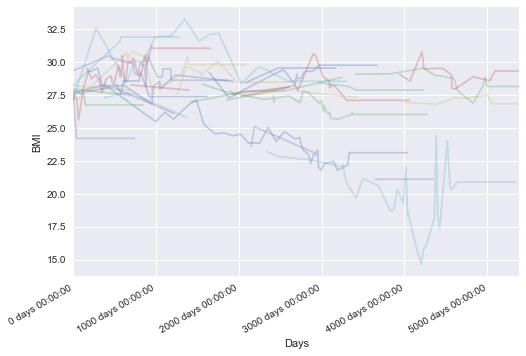

In [43]:
axes = (bmi_by_patient[np.random.choice(bmi_by_patient.columns, 20)]
                    .interpolate(limit=700)
                    .plot(legend=False, alpha=0.3))
axes.set_ylabel('BMI');

Restrict to the first 1-year period

In [25]:
from datetime import timedelta

ONE_YEAR = timedelta(days=365)

In [28]:
bmi_year = bmi_normal_range[bmi_normal_range.RELATIVE_DATE < ONE_YEAR]
bmi_year.shape

(115693, 11)

In [29]:
measurement_counts = bmi_year.groupby('MRN').WEIGHT_DATE.count()

In [30]:
analysis_subset = bmi_year[bmi_year.MRN.isin(measurement_counts[measurement_counts>=5].index)]

In [31]:
analysis_subset.shape

(83100, 11)

In [44]:
weights_by_patient = pd.pivot_table(analysis_subset.assign(Days=analysis_subset.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='Weight_filtered')

In [45]:
weights_by_patient.shape

(365, 7007)

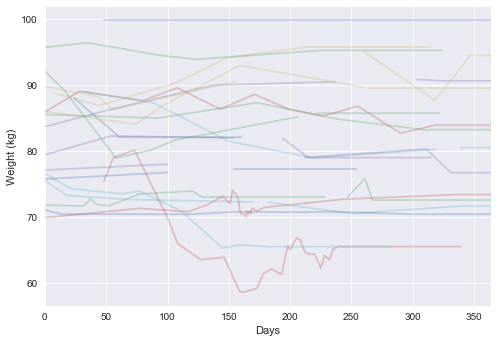

In [37]:
fig, axes = plt.subplots()
(weights_by_patient[np.random.choice(weights_by_patient.columns, 20)].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

In [46]:
bmi_by_patient = pd.pivot_table(analysis_subset.assign(Days=analysis_subset.RELATIVE_DATE.dt.days), 
                                    index='Days', columns='MRN', values='BMI')

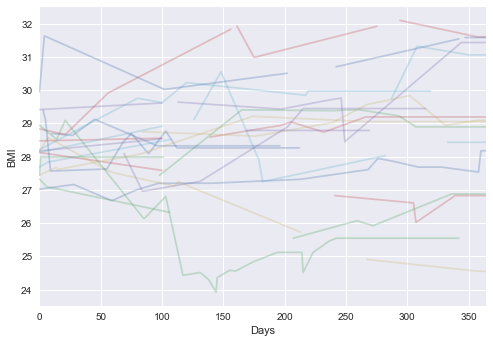

In [47]:
fig, axes = plt.subplots()
(bmi_by_patient[np.random.choice(bmi_by_patient.columns, 20)].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [48]:
bmi_by_patient.to_csv(CLEAN_DATA_DIR+'bmi_by_patient.csv')

In [49]:
weights_by_patient.to_csv(CLEAN_DATA_DIR+'weights_by_patient.csv')

### Lab values

In [42]:
lab_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Lab_20170213.csv', 
                      usecols = ['MRN','LAB_DATE','LAB_VALUE','LAB_NAME','LAB_UNIT'],
                      parse_dates=[1], infer_datetime_format=True)
lab_raw.head()

,MRN,LAB_DATE,LAB_VALUE,LAB_NAME,LAB_UNIT
0,2156149,10/09/2013,1.09,Creat,mg/dL
1,2156149,10/09/2013,1.04,Creat,mg/dL
2,2156149,10/09/2013,0.89,Creat,mg/dL
3,2156149,10/10/2013,0.89,Creat,mg/dL
4,2156149,10/10/2013,0.97,Creat,mg/dL


In [43]:
lab_raw.shape

(8496974, 5)

### ICD codes

In [44]:
icd_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_ICD_9_10_20170116.csv', 
                      parse_dates=[1], infer_datetime_format=True)
icd_raw.head()

,MRN,EVENT_DATE,ICD_CODE,CODE_TYPE
0,2360139,2003-01-07,401.1,9
1,2360139,2002-01-08,401.1,9
2,2360139,2003-01-08,401.1,9
3,2360139,2005-01-11,401.1,9
4,2360139,2004-01-13,401.9,9


In [45]:
icd_raw.shape

(8796137, 4)

In [46]:
icd_raw.CODE_TYPE.value_counts()


9     7098563
10    1697574
Name: CODE_TYPE, dtype: int64

### CPT codes

In [51]:
cpt_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_CPT_20170116.csv',
                     parse_dates=[1], infer_datetime_format=True)
cpt_raw.head()

,MRN,CPT_DATE,CPT_CODE
0,31275076,2012-05-29,43775
1,31275076,2012-05-29,43775
2,31275076,2012-05-29,43775
3,31275076,2012-05-29,43775
4,31275076,2012-05-29,43775


In [52]:
cpt_raw.isnull().mean()


MRN         0.0
CPT_DATE    0.0
CPT_CODE    0.0
dtype: float64

In [53]:
demographics_raw.merge(cpt_raw, left_index=True, right_on='MRN', how='inner').shape

(65769, 12)